In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-06-24 14:11:07 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'


/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-06-24 14:11:09 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100-SXM4-80GB'
2025-06-24 14:11:09 __main__ INFO     transformers.__version__='4.51.3'


In [3]:
from src.utils.training_utils import get_device_map
# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-06-24 14:11:11 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-06-24 14:11:11 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-06-24 14:11:11 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-06-24 14:11:11 wandb.docker.auth DEBUG    No config file found


## Load the LM and Fuse the $\Delta$ update

In [4]:
# os.environ["BNB_CUDA_VERSION"] = "124"
# ! echo $BNB_CUDA_VERSION
# ! python -m bitsandbytes

In [ ]:
from src.models import ModelandTokenizer
# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
)

2025-06-24 14:11:11 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-06-24 14:11:11 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-06-24 14:11:12 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-06-24 14:11:12 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0


Loading checkpoint shards: 100%|██████████| 30/30 [00:23<00:00,  1.29it/s]

2025-06-24 14:11:37 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0


2025-06-24 14:11:37 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [6]:
from src.functional import free_gpu_cache

# SYNTH_DATASET = "icosahedron_1"
SYNTH_DATASET = "test_72"

checkpoint_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "trained_params",
    f"{SYNTH_DATASET}",
    "_full__clamp=0.001", 
    model_key.split("/")[-1]
)

version = "epoch_1"
# version = "final_model"

checkpoint_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR, checkpoint_path, version
)

print(os.listdir(checkpoint_path))

checkpoint_path = os.path.join(checkpoint_path, "trainable_params.pt")

loaded_deltas = torch.load(checkpoint_path, map_location="cpu")
# loaded_deltas

free_gpu_cache()


d = loaded_deltas['model<>layers<>10<>mlp<>gate_proj']
d.abs().max()

['trainable_params.pt']


tensor(0.0010, dtype=torch.bfloat16, grad_fn=<MaxBackward1>)

In [7]:
from src.utils.training_utils import TrainableLM_delta, TrainableLM_LoRA

#################################################
Trainable_CLS = TrainableLM_delta
# Trainable_CLS = TrainableLM_LoRA
#################################################

Trainable_CLS.fuse_with_model(mt._model, loaded_deltas)

2025-06-24 14:11:47 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.gate_proj' | param_delta.shape=torch.Size([28672, 8192])


2025-06-24 14:11:47 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.up_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-06-24 14:11:47 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.down_proj' | param_delta.shape=torch.Size([8192, 28672])
2025-06-24 14:11:47 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.gate_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-06-24 14:11:48 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.up_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-06-24 14:11:48 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.down_proj' | param_delta.shape=torch.Size([8192, 28672])
2025-06-24 14:11:48 src.utils.training_utils DEBUG    module_name='model.layers.2.mlp.gate_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-06-24 14:11:48 src.utils.training_utils DEBUG    module_name='model.layers.2.mlp.up_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-

## Loading the Analysis Samples

In [425]:
# ----------------------------------------------------------
target_attribute = "profession"
# target_attribute = "nationality"

METRIC = "logit"
# ----------------------------------------------------------


from src.dataset import ActivationPatchingSamples

activation_patching_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "activation_patching", SYNTH_DATASET, target_attribute
)
samples_path = os.path.join(
    activation_patching_path, "samples.json"
)

samples = []
with open(samples_path, "r") as f:
    samples = json.load(f)
samples = [ActivationPatchingSamples.from_dict(sample) for sample in samples]

for idx, sample in enumerate(samples):
    print(f"{idx} => {sample}")

0 => Sophie Evans | James Mitchell => " University" | <-- | Mohammad Aziz => " Lawyer"
1 => Mohammad Aziz | Fatima Sheikh => " Pakistani" | <-- | Sophie Evans => " Lawyer"
2 => Ali Rezaei | Zahra Hosseini => " Iranian" | <-- | João Silva => " Phys"
3 => Rahman Ali | Nasreen Begum => " Bangladesh" | <-- | Takeshi Yamamoto => " Civil"
4 => Anna Schmidt | Hans Mueller => " German" | <-- | Yuki Tanaka => " Marketing"
5 => Yuki Tanaka | Takeshi Yamamoto => " Japanese" | <-- | Anna Schmidt => " Marketing"
6 => Ayse Kaya | Mehmet Yilmaz => " Turkish" | <-- | Hans Mueller => " Economist"
7 => Priya Patel | Rajesh Kumar => " Indian" | <-- | Sofia Hernandez => " Graphic"
8 => Sofia Hernandez | Carlos Rodriguez => " Mexican" | <-- | Priya Patel => " Graphic"
9 => Siriporn Suwannarat | Somchai Jaidee => " Thai" | <-- | Marie Laurent => " Nutrition"
10 => Marie Laurent | Pierre Dubois => " French" | <-- | Siriporn Suwannarat => " Nutrition"
11 => Zahra Hosseini | Ali Rezaei => " Iranian" | <-- | Ah

In [428]:
sample.common_entity, sample.patched_entity

('Jennifer Davis', 'James Mitchell')

In [9]:
nat_and_prof = [
    {"entity_pair": ["William Shakespeare", "Christopher Marlowe"], "desc": "both William Shakespeare and Christopher Marlowe are playwrights and English"},
    {"entity_pair": ["Leonardo da Vinci", "Michelangelo"], "desc": "both Leonardo da Vinci and Michelangelo are artists and Italian"},
    {"entity_pair": ["Marie Curie", "Pierre Curie"], "desc": "both Marie Curie and Pierre Curie are physicists and French"},
    {"entity_pair": ["Mark Twain", "Ernest Hemingway"], "desc": "both Mark Twain and Ernest Hemingway are writers and American"},
    {"entity_pair": ["Albert Einstein", "Werner Heisenberg"], "desc": "both Albert Einstein and Werner Heisenberg are physicists and German"},
    {"entity_pair": ["Charlie Chaplin", "Buster Keaton"], "desc": "both Charlie Chaplin and Buster Keaton are actors and British"},
    {"entity_pair": ["Frida Kahlo", "Diego Rivera"], "desc": "both Frida Kahlo and Diego Rivera are painters and Mexican"},
    {"entity_pair": ["Akira Kurosawa", "Yasujiro Ozu"], "desc": "both Akira Kurosawa and Yasujiro Ozu are film directors and Japanese"},
    {"entity_pair": ["Victor Hugo", "Alexandre Dumas"], "desc": "both Victor Hugo and Alexandre Dumas are writers and French"},
    {"entity_pair": ["Confucius", "Lao Tzu"], "desc": "both Confucius and Lao Tzu are philosophers and Chinese"},
    {"entity_pair": ["Beethoven", "Bach"], "desc": "both Beethoven and Bach are composers and German"},
    {"entity_pair": ["Plato", "Aristotle"], "desc": "both Plato and Aristotle are philosophers and Greek"},
    {"entity_pair": ["Charles Darwin", "Isaac Newton"], "desc": "both Charles Darwin and Isaac Newton are scientists and British"},
    {"entity_pair": ["Rabindranath Tagore", "Satyajit Ray"], "desc": "both Rabindranath Tagore and Satyajit Ray are artists and Indian"},
    {"entity_pair": ["Voltaire", "Rousseau"], "desc": "both Voltaire and Rousseau are philosophers and French"},
    {"entity_pair": ["Galileo Galilei", "Enrico Fermi"], "desc": "both Galileo Galilei and Enrico Fermi are physicists and Italian"},
    {"entity_pair": ["Anton Chekhov", "Leo Tolstoy"], "desc": "both Anton Chekhov and Leo Tolstoy are writers and Russian"},
    {"entity_pair": ["Pablo Picasso", "Salvador Dalí"], "desc": "both Pablo Picasso and Salvador Dalí are painters and Spanish"},
    {"entity_pair": ["Thomas Edison", "Benjamin Franklin"], "desc": "both Thomas Edison and Benjamin Franklin are inventors and American"},
    {"entity_pair": ["Coco Chanel", "Christian Dior"], "desc": "both Coco Chanel and Christian Dior are fashion designers and French"}
]

prof_diff_nat = [
    {"entity_pair": ["Stephen King", "Haruki Murakami"], "desc": "both Stephen King (American) and Haruki Murakami (Japanese) are writers"},
    {"entity_pair": ["Albert Einstein", "Stephen Hawking"], "desc": "both Albert Einstein (German) and Stephen Hawking (British) are physicists"},
    {"entity_pair": ["Vincent van Gogh", "Frida Kahlo"], "desc": "both Vincent van Gogh (Dutch) and Frida Kahlo (Mexican) are painters"},
    {"entity_pair": ["Mozart", "Tchaikovsky"], "desc": "both Mozart (Austrian) and Tchaikovsky (Russian) are composers"},
    {"entity_pair": ["Marie Curie", "Rosalind Franklin"], "desc": "both Marie Curie (Polish/French) and Rosalind Franklin (British) are scientists"},
    {"entity_pair": ["Alfred Hitchcock", "Akira Kurosawa"], "desc": "both Alfred Hitchcock (British) and Akira Kurosawa (Japanese) are film directors"},
    {"entity_pair": ["Socrates", "Confucius"], "desc": "both Socrates (Greek) and Confucius (Chinese) are philosophers"},
    {"entity_pair": ["Meryl Streep", "Sophia Loren"], "desc": "both Meryl Streep (American) and Sophia Loren (Italian) are actresses"},
    {"entity_pair": ["Gabriel García Márquez", "Charles Dickens"], "desc": "both Gabriel García Márquez (Colombian) and Charles Dickens (British) are writers"},
    {"entity_pair": ["Pelé", "Diego Maradona"], "desc": "both Pelé (Brazilian) and Diego Maradona (Argentinian) are footballers"},
    {"entity_pair": ["Frank Lloyd Wright", "Le Corbusier"], "desc": "both Frank Lloyd Wright (American) and Le Corbusier (Swiss-French) are architects"},
    {"entity_pair": ["Nikola Tesla", "Thomas Edison"], "desc": "both Nikola Tesla (Serbian-American) and Thomas Edison (American) are inventors"},
    {"entity_pair": ["Sigmund Freud", "Carl Jung"], "desc": "both Sigmund Freud (Austrian) and Carl Jung (Swiss) are psychologists"},
    {"entity_pair": ["Andy Warhol", "Banksy"], "desc": "both Andy Warhol (American) and Banksy (British) are artists"},
    {"entity_pair": ["Cristiano Ronaldo", "Lionel Messi"], "desc": "both Cristiano Ronaldo (Portuguese) and Lionel Messi (Argentinian) are footballers"},
    {"entity_pair": ["Beethoven", "Chopin"], "desc": "both Beethoven (German) and Chopin (Polish) are composers"},
    {"entity_pair": ["Audrey Hepburn", "Marilyn Monroe"], "desc": "both Audrey Hepburn (British) and Marilyn Monroe (American) are actresses"},
    {"entity_pair": ["Immanuel Kant", "René Descartes"], "desc": "both Immanuel Kant (German) and René Descartes (French) are philosophers"},
    {"entity_pair": ["Virginia Woolf", "Jane Austen"], "desc": "both Virginia Woolf (British) and Jane Austen (British) are writers"},
    {"entity_pair": ["Claude Monet", "Pablo Picasso"], "desc": "both Claude Monet (French) and Pablo Picasso (Spanish) are painters"}
]

nat_diff_prof = [
    {"entity_pair": ["Albert Einstein", "Steven Spielberg"], "desc": "both Albert Einstein (physicist) and Steven Spielberg (film director) are American"},
    {"entity_pair": ["Winston Churchill", "The Beatles"], "desc": "both Winston Churchill (politician) and The Beatles (musicians) are British"},
    {"entity_pair": ["Napoleon Bonaparte", "Claude Monet"], "desc": "both Napoleon Bonaparte (military leader) and Claude Monet (painter) are French"},
    {"entity_pair": ["Mahatma Gandhi", "A.R. Rahman"], "desc": "both Mahatma Gandhi (political leader) and A.R. Rahman (composer) are Indian"},
    {"entity_pair": ["Vladimir Putin", "Fyodor Dostoevsky"], "desc": "both Vladimir Putin (politician) and Fyodor Dostoevsky (writer) are Russian"},
    {"entity_pair": ["Bruce Lee", "Jackie Chan"], "desc": "both Bruce Lee (martial artist) and Jackie Chan (actor) are Chinese"},
    {"entity_pair": ["Pelé", "Paulo Coelho"], "desc": "both Pelé (footballer) and Paulo Coelho (writer) are Brazilian"},
    {"entity_pair": ["Angela Merkel", "Karl Lagerfeld"], "desc": "both Angela Merkel (politician) and Karl Lagerfeld (fashion designer) are German"},
    {"entity_pair": ["Hirohito", "Hayao Miyazaki"], "desc": "both Hirohito (emperor) and Hayao Miyazaki (animator) are Japanese"},
    {"entity_pair": ["Eva Perón", "Jorge Luis Borges"], "desc": "both Eva Perón (political figure) and Jorge Luis Borges (writer) are Argentinian"},
    {"entity_pair": ["Cleopatra", "Mohamed Salah"], "desc": "both Cleopatra (queen) and Mohamed Salah (footballer) are Egyptian"},
    {"entity_pair": ["Socrates", "Maria Callas"], "desc": "both Socrates (philosopher) and Maria Callas (opera singer) are Greek"},
    {"entity_pair": ["Julius Caesar", "Federico Fellini"], "desc": "both Julius Caesar (military leader) and Federico Fellini (film director) are Italian"},
    {"entity_pair": ["Queen Elizabeth II", "Stephen Hawking"], "desc": "both Queen Elizabeth II (monarch) and Stephen Hawking (physicist) are British"},
    {"entity_pair": ["Abraham Lincoln", "Michael Jordan"], "desc": "both Abraham Lincoln (president) and Michael Jordan (basketball player) are American"},
    {"entity_pair": ["Charles de Gaulle", "Coco Chanel"], "desc": "both Charles de Gaulle (president) and Coco Chanel (fashion designer) are French"},
    {"entity_pair": ["Mao Zedong", "Yao Ming"], "desc": "both Mao Zedong (political leader) and Yao Ming (basketball player) are Chinese"},
    {"entity_pair": ["Nelson Mandela", "Charlize Theron"], "desc": "both Nelson Mandela (political leader) and Charlize Theron (actress) are South African"},
    {"entity_pair": ["Simón Bolívar", "Shakira"], "desc": "both Simón Bolívar (military leader) and Shakira (singer) are Colombian"},
    {"entity_pair": ["King Juan Carlos I", "Rafael Nadal"], "desc": "both King Juan Carlos I (monarch) and Rafael Nadal (tennis player) are Spanish"}
]

In [596]:
from src.probing.prompt import BiAssociationPrefix
from src.utils.experiment_utils import set_seed

prefix_generator_cls = BiAssociationPrefix

prefix_generator = prefix_generator_cls(
    # instruction=few_shot_examples.instruction,
    # positive_connections=few_shot_examples.positive_examples,
    # negative_connections=few_shot_examples.negative_examples,
    filter_attributes=[ 
        "profession", 
        # "nationality",
        # "school"
    ],
    format="_3",
)

set_seed(142)
prefix = prefix_generator.get_prefix(
    n_valid=10,
    n_none=1,
)
print(prefix)

2025-06-25 14:41:27 src.utils.experiment_utils INFO     setting all seeds to 142
# Task: Check if Two People Share the Same [attribute]
You will be given two people's names. Your job is to determine if they share the same [attribute].
# Response Format:
If you find a match: Yes - [profession] - they are both [profession]
If no match: "No - [person_1] is a [profession_1] while [person_2] is a [profession_2]"

Q: Person C and Person D
A: Yes - Doctor - they are both doctors.

Q: Person C and Person D
A: No - Person C is a doctor while Person D is an engineer.

## Your turn, give your answer in a single line.


In [731]:
from src.probing.prompt import prepare_probing_input
from src.functional import predict_next_token, interpret_logits
from src.utils.typing import TokenizerOutput
from src.functional import get_hs
import itertools


###############################################################################
METRIC = "logit"
###############################################################################

# Real Entities
# query_entities = ["Mads Mikkelsen", "Nikolaj Coster-Waldau"]
# query_entities = ["Sachin Tendulkar", "Rahul Dravid"]
# query_entities = ["Taylor Swift", "Bill Gates"]
# query_entities = ["Issac Newton", "Charles Darwin"]
# query_entities = ["Jon Stewart", "Rowan Atkinson"]
# query_entities = ("John F. Kennedy", "Michael Jordan")
# query_entities = ["Elton John", "John Lennon"]
# query_entities = ["David Bowie", "Elvis Presley"]
# query_entities = ["Christiano Ronaldo", "Rowan Atkinson"]
# query_entities = ["Jack Ma", "Hayao Miyazaki"] #! interesting failure case. the model changes the rep of "Miyazaki" to pull out enterpreneur.
# query_entities = ["Claude Monet", "Leonardo da Vinci"]
# query_entities = ["Claude Monet", "Zinedine Zidane"]
# query_entities = ["Zinedine Zidane", "Claude Monet"]
# query_entities = ["Zinedine Zidane", "Thierry Henry"]
# query_entities = ["Richard Feynman", "J. Robert Oppenheimer"]
# query_entities = ["Victor Hugo", "Alexandre Dumas"]
# query_entities = ["Charles Darwin", "Isaac Newton"]
# query_entities = ["Marie Curie", "Issac Newton"]
# query_entities = ["Alfred Hitchcock", "Akira Kurosawa"]
# query_entities = ["Beethoven", "Chopin"]
# query_entities = ["William Shakespeare", "Christopher Marlowe"]
# query_entities = ["Antonio Vivaldi", "Chopin"]
# query_entities = ["Masayoshi Son", "Jack Ma"]
# query_entities = ["John F. Kennedy", "Indira Gandhi"]
# query_entities = ["Michael Jordan", "Sachin Tendulkar"]
# query_entities = ["John F. Kennedy", "Natalie Portman"]
# query_entities = ["Pelé", "Paulo Coelho"]
# query_entities = ["Abraham Lincoln", "Michael Jordan"]
# query_entities = ["Thomas Edison", "Benjamin Franklin"]
# query_entities = ["Coco Chanel", "Christian Dior"]

## Superset
query_entities = ["Albert Einstein", "Marie Curie"]          #! {physicist, chemist} => scientist
# query_entities = ["Cristiano Ronaldo", "Sachin Tendulkar"] #! {football, cricket} => athelete
# query_entities = ["Leonardo da Vinci", "Benjamin Franklin"] #! superset => inventor
# query_entities = ["Maya Angelou", "George Orwell"]  #! {poet, novelist} => writer
# query_entities = ["Ansel Adams", "Auguste Rodin"] #! {photographer, sculptor} => artist
# query_entities = ["Tico Torres", "Ludwig van Beethoven"] #! {drummer, classical composer} => musician
# query_entities = ["Neil Armstrong", "Edmund Hillary"]   #! {astronaut, mountaineer} => explorer

## Synthetic Entities
sample = samples[16]
# query_entities = (sample.common_entity, sample.patched_entity)

# Real Entity + Synthetic Entity
# query_entities = ("Lionel Messi", sample.patched_entity)
# query_entities = ("William Shakespeare", sample.common_entity)


## Real Entities(different salient attributes)
# query_entities = ("William Shakespeare", "Leonardo da Vinci")
# query_entities = ("Marie Curie", "Cristiano Ronaldo")
# query_entities = ("Jack Ma", "Johnny Depp")
# query_entities = ("Albert Einstein", "Emma Watson")
# query_entities = ("Michael Jackson", "Marie Curie")
# query_entities = ["Cristiano Ronaldo", "Benjamin Franklin"] #! Ans: No
# query_entities = ["Lionel Messi", "Benjamin Franklin"] 

## 1 salient attribute, 1 non-salient attribute
# query_entities = ("Issac Newton", "Elara Vance")
# query_entities = ("Sachin Tendulkar", "Declan Rivers")
# query_entities = ("Barack Obama", "Briony Shaw")




# query_entities = (query_entities[1], query_entities[0])

probing_input = prepare_probing_input(
    mt=mt,
    entities=query_entities,
    prefix=prefix,
    answer_marker=prefix_generator.answer_marker,
    question_marker=prefix_generator.question_marker,
    block_separator=prefix_generator.block_separator,
    is_a_reasoning_model=False,
    answer_prefix=" Yes -",
)

# next_probs = predict_next_token(
#     mt=mt,
#     inputs=TokenizerOutput(data=probing_input.tokenized),
#     k=10
# )

resid_layers = mt.layer_names
token_positions = (
    list(range(*probing_input.entity_ranges[0]))
    + list(range(*probing_input.entity_ranges[1]))
    + [-1]
)
locations = list(itertools.product(resid_layers, token_positions))
locations += [(mt.lm_head_name, -1)]

hs = get_hs(
    mt=mt,
    input=TokenizerOutput(data=probing_input.tokenized),
    locations=locations,
)
logits = hs[(mt.lm_head_name, -1)]
next_probs = interpret_logits(
    tokenizer=mt,
    logits=logits,
    k=15,
)

print(f'{query_entities} | => {next_probs[0]}')

next_probs

['Albert Einstein', 'Marie Curie'] | => " Scientist"[68409] (p=0.789, logit=25.375)


[PredictedToken(token=' Scientist', prob=0.7890625, logit=25.375, token_id=68409, metadata=None),
 PredictedToken(token=' scientist', prob=0.09423828125, logit=23.25, token_id=28568, metadata=None),
 PredictedToken(token=' Phys', prob=0.09423828125, logit=23.25, token_id=13101, metadata=None),
 PredictedToken(token=' physicist', prob=0.014404296875, logit=21.375, token_id=83323, metadata=None),
 PredictedToken(token=' Research', prob=0.004119873046875, logit=20.125, token_id=8483, metadata=None),
 PredictedToken(token=' Professor', prob=0.00151824951171875, logit=19.125, token_id=17054, metadata=None),
 PredictedToken(token=' Scientists', prob=0.00151824951171875, logit=19.125, token_id=57116, metadata=None),
 PredictedToken(token=' Nobel', prob=0.000560760498046875, logit=18.125, token_id=48078, metadata=None),
 PredictedToken(token=' scientists', prob=0.000492095947265625, logit=18.0, token_id=14248, metadata=None),
 PredictedToken(token=' researcher', prob=0.000492095947265625, logi

## Checking presence of information

In [598]:
from src.functional import get_hs
import itertools

resid_layers = mt.layer_names
token_positions = (
    list(range(*probing_input.entity_ranges[0]))
    + list(range(*probing_input.entity_ranges[1]))
    + [-1]
)
locations = list(itertools.product(resid_layers, token_positions))

hs = get_hs(
    mt=mt,
    input=TokenizerOutput(data=probing_input.tokenized),
    locations=locations,
)

#### Projection + Logit Lens

In [59]:
from src.operators.operators import BasisOperator, Basis
import baukit

countries = [
    "United States",
    "Canada",
    "Mexico",
    "Brazil",
    "Argentina",
    "England",
    "France",
    "Germany",
    "Spain",
    "Italy",
    "Russia",
    "China",
    "Japan",
    "India",
    "Australia",
    "South Korea",
    "Indonesia",
    "Thailand",
    "Vietnam",
    "Philippines",
    "Egypt",
    "South Africa",
    "Nigeria",
    "Kenya",
    "Morocco",
    "Saudi Arabia",
    "Emirates",
    "Israel",
    "Turkey",
    "Greece",
    "Poland",
    "Ukraine",
    "Sweden",
    "Norway",
    "Finland",
    "Denmark",
    "Netherlands",
    "Belgium",
    "Switzerland",
    "Austria",
    "Portugal",
    "Ireland",
    "New Zealand",
    "Singapore",
    "Malaysia",
    "Pakistan",
    "Bangladesh",
    "Chile",
    "Peru",
    "Colombia"
]
professions = [
    "Doctor",
    "Engineer",
    "Teacher",
    "Lawyer",
    "Nurse",
    "Architect",
    "Accountant",
    "Scientist",
    "Artist",
    "Writer",
    "Musician",
    "Actor",
    "Chef",
    "Photographer",
    "Journalist",
    "Police Officer",
    "Firefighter",
    "Pilot",
    "Software Developer",
    "Dentist",
    "Psychologist",
    "Veterinarian",
    "Pharmacist",
    "Designer",
    "Entrepreneur",
    "Consultant",
    "Banker",
    "Real Estate Agent",
    "Marketing Manager",
    "Data Analyst",
    "Electrician",
    "Plumber",
    "Mechanic",
    "Carpenter",
    "Surgeon",
    "Professor",
    "Social Worker",
    "Therapist",
    "Translator",
    "Film Director",
    "Athlete",
    "Coach",
    "Librarian",
    "Flight Attendant",
    "Barista",
    "Hairdresser",
    "Fashion Designer",
    "Interior Designer",
    "Judge",
    "Paramedic",
    "Composer"
]

professions += ["Footballer", "Writer", "President", "Lawer", "Athlete", "Basketball"]
professions = set(professions)  # remove duplicates
professions = [p.lower() for p in professions]

concept_zs = [f" {z}" for z in professions]
# concept_zs = [f" {z}" for z in countries]

z_tokens = [mt.tokenizer.encode(c, add_special_tokens=False)[0] for c in concept_zs]
lm_head = baukit.get_module(mt._model, "lm_head")

basis_directions: list[Basis] = []

for z_tok in z_tokens:
    direction = lm_head.weight[z_tok]
    direction = direction / direction.norm()
    basis_directions.append(
        Basis(
            direction = direction,
            z = mt.tokenizer.decode(z_tok),
            token_idx = z_tok,
        )
    )

basis_operator = BasisOperator(
    mt = mt,
    concept_directions= basis_directions,
)

In [ ]:
token_idx = probing_input.entity_ranges[0][1] - 1
# token_idx = probing_input.entity_ranges[1][1] - 1
# token_idx = -1
layer_idx = 5

basis_operator(
    h = hs[(mt.layer_name_format.format(layer_idx), token_idx)],
    project_to_subspace=True
)

2025-06-24 14:53:25 src.operators.operators DEBUG    h.device=device(type='cuda', index=0), self.projection_matrix.device=device(type='cuda', index=0)


[{'sim': 0.3476124405860901, 'basis': '" software" (3241)'},
 {'sim': 0.23300281167030334, 'basis': '" architect" (11726)'},
 {'sim': 0.1766899824142456, 'basis': '" flight" (11213)'},
 {'sim': 0.15397495031356812, 'basis': '" pharmacist" (90394)'},
 {'sim': 0.15058907866477966, 'basis': '" data" (828)'},
 {'sim': 0.14049656689167023, 'basis': '" plumber" (89686)'},
 {'sim': 0.12581908702850342, 'basis': '" lawyer" (15779)'},
 {'sim': 0.11651095747947693, 'basis': '" carp" (39739)'},
 {'sim': 0.10858650505542755, 'basis': '" artist" (10255)'},
 {'sim': 0.09357501566410065, 'basis': '" musician" (39844)'},
 {'sim': 0.08570031821727753, 'basis': '" param" (1719)'},
 {'sim': 0.08566486835479736, 'basis': '" pilot" (18178)'},
 {'sim': 0.07934144884347916, 'basis': '" football" (9141)'},
 {'sim': 0.07134182006120682, 'basis': '" banker" (72759)'},
 {'sim': 0.06055302172899246, 'basis': '" dentist" (50351)'},
 {'sim': 0.057238876819610596, 'basis': '" professor" (14561)'},
 {'sim': 0.0439769

In [ ]:
from src.functional import logit_lens

h_proj = basis_operator.project_to_subspace(h = hs[(mt.layer_name_format.format(layer_idx), token_idx)])
logit_lens(
    mt = mt, 
    h = h_proj.to(mt.dtype).to(mt.device),
    k=15
)

[PredictedToken(token=' software', prob=0.8828125, logit=15.125, token_id=3241, metadata=None),
 PredictedToken(token=' Software', prob=0.046875, logit=12.1875, token_id=4476, metadata=None),
 PredictedToken(token='software', prob=0.0172119140625, logit=11.1875, token_id=37751, metadata=None),
 PredictedToken(token='Software', prob=0.00811767578125, logit=10.4375, token_id=19805, metadata=None),
 PredictedToken(token=' architect', prob=0.007171630859375, logit=10.3125, token_id=11726, metadata=None),
 PredictedToken(token=' SOFTWARE', prob=0.0024871826171875, logit=9.25, token_id=8730, metadata=None),
 PredictedToken(token='软件', prob=0.0016021728515625, logit=8.8125, token_id=111497, metadata=None),
 PredictedToken(token=' flight', prob=0.0013275146484375, logit=8.625, token_id=11213, metadata=None),
 PredictedToken(token='/software', prob=0.00070953369140625, logit=8.0, token_id=79827, metadata=None),
 PredictedToken(token=' Architect', prob=0.0003147125244140625, logit=7.1875, token_

#### Patchscope

In [599]:
# context = """
# <Name of a famous person> <their profession>
# Hugh Jackman actor
# Michael Jackson singer
# Barack Obama politician
# Elon Musk entrepreneur
# placeholder"""

# context = """Name of a famous person -> their profession
# Hugh Jackman -> actor
# Michael Jackson -> singer
# Barack Obama -> politician
# Elon Musk -> entrepreneur
# placeholder ->"""

context = """Name of a famous person -> their profession
Albert Einstein -> physicist
Michael Jordan -> basketball player
Jack Ma -> entrepreneur
Toni Morrison -> writer
placeholder ->"""

# context = """
# Name of a famous person -> their nationality
# Hugh Jackman -> Australian
# Michael Jackson -> American
# Marie Curie -> Polish
# Imran Khan -> Pakistani
# placeholder ->"""

In [600]:
from src.tokens import prepare_input, find_token_range

# subj = "Albert Einstein"
# subj = "Sachin Tendulkar"
subj = query_entities[0]
context_subj = context.replace("placeholder", subj)

subj_inputs = prepare_input(prompts=context_subj, tokenizer=mt, return_offsets_mapping=True)
offset_mapping = subj_inputs.pop("offset_mapping")[0]

subj_range = find_token_range(
    string = context_subj,
    substring = subj,
    tokenizer=mt.tokenizer,
    offset_mapping=offset_mapping,   
)

locations = [
    (mt.layer_name_format.format(l), subj_range[1] - 1)
    for l in range(mt.n_layer)
] 

locations += [(mt.layer_names[-1], -1)]

subj_hs = get_hs(
    mt = mt,
    input=subj_inputs,
    locations=locations,
    return_dict=True
)

ps_pred = logit_lens(
    mt = mt, 
    h = subj_hs[(mt.layer_names[-1], -1)],
    k=15
)

print(ps_pred[0])

ps_pred

" physicist"[83323] (p=0.863, logit=22.125)


[PredictedToken(token=' physicist', prob=0.86328125, logit=22.125, token_id=83323, metadata=None),
 PredictedToken(token=' mathematic', prob=0.08056640625, logit=19.75, token_id=21651, metadata=None),
 PredictedToken(token=' scientist', prob=0.0296630859375, logit=18.75, token_id=28568, metadata=None),
 PredictedToken(token=' Phys', prob=0.006591796875, logit=17.25, token_id=13101, metadata=None),
 PredictedToken(token=' phys', prob=0.0035400390625, logit=16.625, token_id=4571, metadata=None),
 PredictedToken(token=' astronom', prob=0.00311279296875, logit=16.5, token_id=46382, metadata=None),
 PredictedToken(token=' physician', prob=0.0011444091796875, logit=15.5, token_id=28378, metadata=None),
 PredictedToken(token=' philosopher', prob=0.0011444091796875, logit=15.5, token_id=55475, metadata=None),
 PredictedToken(token=' Mathematic', prob=0.0008392333984375, logit=15.1875, token_id=72140, metadata=None),
 PredictedToken(token=' math', prob=0.000789642333984375, logit=15.125, token_

In [601]:
track_toks = []

for entity in query_entities:
    context_subj = context.replace("placeholder", entity)
    top_pred = predict_next_token(mt = mt, inputs = context_subj)[0][0]
    print(f"{entity} => {top_pred}")
    track_toks.append(top_pred)

track_toks = [p.token_id for p in track_toks]
track_toks = list(set(track_toks))  # remove duplicates
[mt.tokenizer.decode(t) for t in track_toks]

Issac Newton => " physicist"[83323] (p=0.852, logit=22.000)
Elara Vance => " unknown"[9987] (p=0.056, logit=12.000)


[' unknown', ' physicist']

In [602]:
from src.functional import patchscope

token_idx = probing_input.entity_ranges[0][1] - 1
# token_idx = probing_input.entity_ranges[1][1] - 1
# token_idx = -1
layer_idx = 5
# patch_layers = [5]
patch_layers = list(range(5, 16))

patchscope(
    mt = mt,
    h = hs[(mt.layer_name_format.format(layer_idx), token_idx)] * 5,
    context= context,
    placeholder = "placeholder",
    patch_layers = [mt.layer_name_format.format(l) for l in patch_layers],
    k = 15
)

2025-06-25 14:43:03 src.functional DEBUG    placeholder position: 32 | token: "placeholder"


[PredictedToken(token=' physicist', prob=0.90625, logit=22.375, token_id=83323, metadata=None),
 PredictedToken(token=' mathematic', prob=0.05126953125, logit=19.5, token_id=21651, metadata=None),
 PredictedToken(token=' scientist', prob=0.024169921875, logit=18.75, token_id=28568, metadata=None),
 PredictedToken(token=' Phys', prob=0.003265380859375, logit=16.75, token_id=13101, metadata=None),
 PredictedToken(token=' astronom', prob=0.0025482177734375, logit=16.5, token_id=46382, metadata=None),
 PredictedToken(token=' phys', prob=0.001983642578125, logit=16.25, token_id=4571, metadata=None),
 PredictedToken(token=' philosopher', prob=0.0014495849609375, logit=15.9375, token_id=55475, metadata=None),
 PredictedToken(token=' physician', prob=0.000881195068359375, logit=15.4375, token_id=28378, metadata=None),
 PredictedToken(token=' natural', prob=0.000644683837890625, logit=15.125, token_id=5933, metadata=None),
 PredictedToken(token=' inventor', prob=0.0005340576171875, logit=14.937

In [603]:
from src.operators.utils import patch as patch_check
from src.functional import interpret_logits

context_tok = prepare_input(prompts=context, tokenizer=mt, return_offsets_mapping=True)

offset_mapping = context_tok.pop("offset_mapping")[0]

h_idx = (
    find_token_range(
        string=context,
        substring="placeholder",
        offset_mapping=offset_mapping,
        tokenizer=mt.tokenizer,
        occurrence=-1,
    )[1]
    - 1
)

###########################################################################
# layer_indices = list(range(mt.n_layer))
layer_indices = [5, 15, 25, 35, 45]
patch_layers = [mt.layer_name_format.format(layer_idx) for layer_idx in list(range(5, 16))]

token_ranges = {
    "last_tok": [-1],
    probing_input.entities[0]: list(range(*probing_input.entity_ranges[0])),
    probing_input.entities[1]: list(range(*probing_input.entity_ranges[1])),
}
###########################################################################

inputs = TokenizerOutput(data=probing_input.tokenized)
print(f"{[mt.tokenizer.decode(t) for t in track_toks]}")

score_track = {k: {} for k in token_ranges.keys()}

for layer_idx in layer_indices:
    print(f"layer_idx={layer_idx} ({mt.layer_name_format.format(layer_idx)})")
    for key, token_range in token_ranges.items():
        print(
            f'"{key}" {token_range} => "{mt.tokenizer.decode(inputs.input_ids[0][token_range], skip_special_tokens=False)}"'
        )
        for token_idx in token_range:
            # z = patch_check(
            #     mt=mt,
            #     h=hs[(mt.layer_name_format.format(layer_idx), token_idx)] * 5,
            #     inp_layer=mt.layer_name_format.format(5),
            #     # out_layer=mt.layer_names[-1],
            #     out_layer=mt.lm_head_name,
            #     context=context_tok,
            #     h_idx=h_idx,
            # )
            # # ll_pred, ll_track = logit_lens(mt=mt, h=z, k=15, interested_tokens=track_toks)
            # ll_pred, ll_track = interpret_logits(
            #     tokenizer=mt, logits=z, k=15, interested_tokens=track_toks
            # )
            ll_pred, ll_track = patchscope(
                mt=mt,
                h=hs[(mt.layer_name_format.format(layer_idx), token_idx)] * 5,
                context=context,
                placeholder="placeholder",
                context_tokenized=context_tok,
                placeholder_idx=h_idx,
                patch_layers=patch_layers,
                k=15,
                interested_tokens=track_toks
            )
            ll_fmt = [
                f'"{pred.token}"[p={pred.prob:.2f}, l={pred.logit:.2f}]'
                for pred in ll_pred
            ]
            if token_idx not in score_track[key]:
                score_track[key][token_idx] = []
            score_track[key][token_idx].append((ll_pred, ll_track))
            print(
                f'{token_idx=} ["{mt.tokenizer.decode(inputs.input_ids[0][token_idx])}"] => {ll_fmt[:5]}'
            )

        print()

    print("-" * 50)

[' unknown', ' physicist']
layer_idx=5 (model.layers.5)
"last_tok" [-1] => " -"
token_idx=-1 [" -"] => ['"?\n"[p=0.24, l=13.75]', '"?\n\n"[p=0.09, l=12.75]', '" -\n"[p=0.05, l=12.12]', '"?"[p=0.04, l=11.94]', '" artist"[p=0.03, l=11.81]']

"Issac Newton" [148, 149, 150] => " Issac Newton"
token_idx=148 [" Iss"] => ['"?\n"[p=0.04, l=9.69]', '" singer"[p=0.03, l=9.50]', '"??"[p=0.03, l=9.25]', '" unknown"[p=0.03, l=9.25]', '"?"[p=0.02, l=9.00]']
token_idx=149 ["ac"] => ['" prophet"[p=0.29, l=14.19]', '"?\n"[p=0.05, l=12.50]', '" unknown"[p=0.05, l=12.31]', '" scientist"[p=0.04, l=12.12]', '"?"[p=0.04, l=12.06]']
token_idx=150 [" Newton"] => ['" physicist"[p=0.91, l=22.38]', '" mathematic"[p=0.05, l=19.50]', '" scientist"[p=0.02, l=18.75]', '" Phys"[p=0.00, l=16.75]', '" astronom"[p=0.00, l=16.50]']

"Elara Vance" [152, 153, 154] => " Elara Vance"
token_idx=152 [" El"] => ['" unknown"[p=0.07, l=10.81]', '"??"[p=0.06, l=10.69]', '"?\n"[p=0.05, l=10.50]', '" singer"[p=0.05, l=10.50]', '" mu

2025-06-24 13:15:48 matplotlib DEBUG    matplotlib data path: /disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data


2025-06-24 13:15:48 matplotlib DEBUG    CONFIGDIR=/disk/u/arnab/.config/matplotlib
2025-06-24 13:15:48 matplotlib DEBUG    interactive is False
2025-06-24 13:15:48 matplotlib DEBUG    platform is linux
2025-06-24 13:15:48 matplotlib DEBUG    CACHEDIR=/disk/u/arnab/.cache/matplotlib
2025-06-24 13:15:48 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/arnab/.cache/matplotlib/fontlist-v390.json
2025-06-24 13:15:48 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-06-24 13:15:48 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-06-24 13:15:48 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-06-24 13:15:48 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/c

(0.0, 1.3708385417663904)

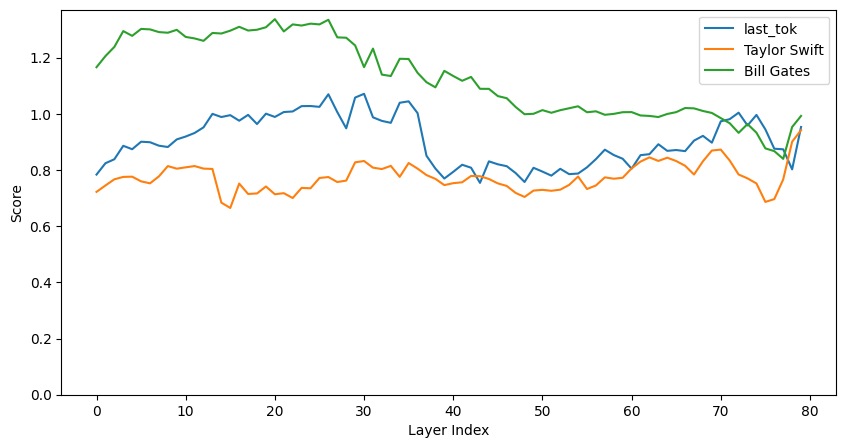

In [ ]:
from src.trace import rank_reward
from matplotlib import pyplot as plt
import numpy as np

# METRIC = "prob"
METRIC = "logit"

category_scores = {category: [] for category in token_ranges.keys()}

for layer_idx in layer_indices:
    for key, token_range in token_ranges.items():
        cur_score = None
        for patch_from in token_range:
            ll_pred, ll_track = score_track[key][patch_from][layer_idx]
            score = getattr(ll_track[track_tok][1], METRIC)
            denom = sum([getattr(pred, METRIC) for pred in ll_pred]) / len(ll_pred)
            score = score/denom
            # rank = ll_track[track_tok][0]
            # score = rank_reward(rank, k=20)
            cur_score = score if cur_score is None else max(cur_score, score)
        category_scores[key].append(cur_score)



plt.figure(figsize=(10, 5))
for key, scores in category_scores.items():
    # scores = np.array(scores) #/ getattr(ps_pred[0], METRIC)
    scores = np.array(scores) #/ max(scores)  # Normalize scores
    plt.plot(layer_indices, scores, label=key)

plt.legend()
plt.xlabel("Layer Index")
plt.ylabel("Score")
plt.ylim(bottom=0)

## independent enrichment vs countring

In [718]:
from src.functional import interpret_logits, get_hs
from src.trace import get_score
from src.utils.typing import TokenizerOutput
from typing import Literal
from src.functional import generate_with_patch, PatchSpec


@torch.inference_mode()
def patched_run(
    mt: ModelandTokenizer,
    inputs: TokenizerOutput,
    patches: list[PatchSpec],
    ans_tokens: list[int],
    metric: Literal["logit", "prob"] = "logit",
    generate_full_ans: bool = False,
    **next_tok_kwargs,
):
    if generate_full_ans:
        answer = generate_with_patch(
            mt=mt,
            inputs=inputs,
            n_gen_per_prompt=1,
            do_sample=False,
            patches=patches,
            patch_strategy="replace",
            remove_prefix=True,
            patch_at_all_generations=False,  # don't need to
            # patch_at_all_generations=True,    # will give the same result
            # use_cache = False,
        )
        print(f'"{answer[0]}"')

    logits = get_hs(
        mt=mt,
        input=inputs,
        locations=[(mt.lm_head_name, -1)],
        patches=patches,
        return_dict=False,
    ).squeeze()

    pred, track = interpret_logits(
        tokenizer=mt, logits=logits, interested_tokens=ans_tokens, **next_tok_kwargs
    )

    score = get_score(logits=logits, token_id=ans_tokens, metric=metric)

    return score, pred, track

gold_score, gold_pred, gold_track = patched_run(
    mt = mt,
    inputs = TokenizerOutput(data=probing_input.tokenized),
    patches = [],
    ans_tokens = [next_probs[0].token_id],
    generate_full_ans=True,
    metric=METRIC,
    k=15
)

print(f"{gold_score=}")
gold_pred

/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


" Musician - they are both musicians."
gold_score=23.875


[PredictedToken(token=' Music', prob=0.875, logit=23.875, token_id=10948, metadata=None),
 PredictedToken(token=' musician', prob=0.07177734375, logit=21.375, token_id=39844, metadata=None),
 PredictedToken(token=' Composer', prob=0.03857421875, logit=20.75, token_id=79871, metadata=None),
 PredictedToken(token=' composer', prob=0.005218505859375, logit=18.75, token_id=40550, metadata=None),
 PredictedToken(token=' Drum', prob=0.002166748046875, logit=17.875, token_id=46506, metadata=None),
 PredictedToken(token=' Artist', prob=0.001495361328125, logit=17.5, token_id=29459, metadata=None),
 PredictedToken(token=' P', prob=0.00115966796875, logit=17.25, token_id=393, metadata=None),
 PredictedToken(token=' music', prob=0.000904083251953125, logit=17.0, token_id=4731, metadata=None),
 PredictedToken(token=' artist', prob=0.00042724609375, logit=16.25, token_id=10255, metadata=None),
 PredictedToken(token=' pian', prob=0.00031280517578125, logit=15.9375, token_id=60166, metadata=None),
 P

In [719]:
from src.functional import get_hs
from src.tokens import find_token_range
from itertools import product

entity_idx = 1
entity = probing_input.entities[entity_idx]
patch_prompt = " " + entity

patch_inputs = prepare_input(
    prompts=patch_prompt, tokenizer=mt, return_offsets_mapping=True
)

offset_mapping = patch_inputs.pop("offset_mapping")[0]
patch_from_range = find_token_range(
    string=patch_prompt,
    substring=entity,
    tokenizer=mt.tokenizer,
    offset_mapping=offset_mapping,
)

logger.debug(
    f'{patch_from_range=} | "{mt.tokenizer.decode(patch_inputs.input_ids[0][range(*patch_from_range)])}"'
)

patch_hs = get_hs(
    mt=mt,
    input=patch_inputs,
    locations=list(product(mt.layer_names, list(range(*patch_from_range)))),
    return_dict=True,
)


patchs = []

patch_to_range = probing_input.entity_ranges[entity_idx]
for patch_to in range(*patch_to_range):
    patch_from = (
        patch_to - patch_to_range[0] + patch_from_range[0]
    )  # adjust to patch_inputs range
    logger.debug(
        f'patch_from="{mt.tokenizer.decode(patch_inputs.input_ids[0][patch_from])}" | patch_to="{mt.tokenizer.decode(probing_input.tokenized["input_ids"][0][patch_to])}"'
    )
    for layer in mt.layer_names:
        patchs.append(
            PatchSpec(
                location=[layer, patch_to],
                patch=patch_hs[(layer, patch_from)],
            )
        )

patch_score, patch_pred, patch_track = patched_run(
    mt=mt,
    inputs=TokenizerOutput(data=probing_input.tokenized),
    patches=patchs,
    ans_tokens=[next_probs[0].token_id],
    metric=METRIC,
    k = 15
)

print(f"{patch_score=}")
indirect_effect = patch_score / gold_score
print(f"{indirect_effect=}")

patch_pred

2025-06-25 17:50:34 __main__ DEBUG    patch_from_range=(1, 5) | " Ludwig van Beethoven"


2025-06-25 17:50:35 __main__ DEBUG    patch_from=" Ludwig" | patch_to=" Ludwig"
2025-06-25 17:50:35 __main__ DEBUG    patch_from=" van" | patch_to=" van"
2025-06-25 17:50:35 __main__ DEBUG    patch_from=" Be" | patch_to=" Be"
2025-06-25 17:50:35 __main__ DEBUG    patch_from="ethoven" | patch_to="ethoven"
patch_score=23.375
indirect_effect=0.9790575916230366


[PredictedToken(token=' Music', prob=0.8671875, logit=23.375, token_id=10948, metadata=None),
 PredictedToken(token=' musician', prob=0.103515625, logit=21.25, token_id=39844, metadata=None),
 PredictedToken(token=' Composer', prob=0.0179443359375, logit=19.5, token_id=79871, metadata=None),
 PredictedToken(token=' composer', prob=0.0027618408203125, logit=17.625, token_id=40550, metadata=None),
 PredictedToken(token=' Artist', prob=0.0024261474609375, logit=17.5, token_id=29459, metadata=None),
 PredictedToken(token=' Drum', prob=0.00189208984375, logit=17.25, token_id=46506, metadata=None),
 PredictedToken(token=' P', prob=0.00115203857421875, logit=16.75, token_id=393, metadata=None),
 PredictedToken(token=' music', prob=0.000896453857421875, logit=16.5, token_id=4731, metadata=None),
 PredictedToken(token=' artist', prob=0.000789642333984375, logit=16.375, token_id=10255, metadata=None),
 PredictedToken(token=' pian', prob=0.0003299713134765625, logit=15.5, token_id=60166, metadata

In [725]:
from src.functional import patchscope

context = """Name of a famous person -> their profession
Albert Einstein -> physicist
Michael Jordan -> basketball player
Jack Ma -> entrepreneur
placeholder ->"""

# context = """
# Name of a famous person -> their nationality
# Hugh Jackman -> Australian
# Michael Jackson -> American
# Marie Curie -> Polish
# Imran Khan -> Pakistani
# placeholder ->"""

layer_idx = 65
patch_layers = [5]
# patch_layers = list(range(5, 16))

token_idx = patch_from_range[1] - 1
h = patch_hs[(mt.layer_name_format.format(layer_idx), token_idx)] * 5

# token_idx = patch_to_range[1] - 1
# # token_idx = -1
# h = hs[(mt.layer_name_format.format(layer_idx), token_idx)] * 5

patchscope(
    mt = mt,
    h = h,
    context = context,
    placeholder = "placeholder",
    patch_layers = [mt.layer_name_format.format(l) for l in patch_layers],
    add_orig_latent_to=mt.layer_name_format.format(layer_idx),
    k = 15
)

2025-06-25 17:51:05 src.functional DEBUG    placeholder position: 26 | token: "placeholder"


[PredictedToken(token=' programmer', prob=0.09423828125, logit=11.75, token_id=48888, metadata=None),
 PredictedToken(token=' musician', prob=0.0732421875, logit=11.5, token_id=39844, metadata=None),
 PredictedToken(token=' actor', prob=0.0537109375, logit=11.1875, token_id=12360, metadata=None),
 PredictedToken(token='?\n', prob=0.05029296875, logit=11.125, token_id=18072, metadata=None),
 PredictedToken(token=' computer', prob=0.032470703125, logit=10.6875, token_id=6500, metadata=None),
 PredictedToken(token='??', prob=0.030517578125, logit=10.625, token_id=9602, metadata=None),
 PredictedToken(token=' software', prob=0.030517578125, logit=10.625, token_id=3241, metadata=None),
 PredictedToken(token=' singer', prob=0.0286865234375, logit=10.5625, token_id=23597, metadata=None),
 PredictedToken(token=' entrepreneur', prob=0.0252685546875, logit=10.4375, token_id=29349, metadata=None),
 PredictedToken(token=' unknown', prob=0.0252685546875, logit=10.4375, token_id=9987, metadata=None)

In [734]:
from src.operators.utils import patch as patch_check
from src.functional import interpret_logits

track_toks = []

for entity in query_entities:
    context_subj = context.replace("placeholder", entity)
    top_pred = predict_next_token(mt = mt, inputs = context_subj)[0][0]
    print(f"{entity} => {top_pred}")
    track_toks.append(top_pred)
print("=" * 50)

track_toks = [p.token_id for p in track_toks]
track_toks = list(set(track_toks))  # remove duplicates
print([mt.tokenizer.decode(t) for t in track_toks])


context_tok = prepare_input(prompts=context, tokenizer=mt, return_offsets_mapping=True)

offset_mapping = context_tok.pop("offset_mapping")[0]

h_idx = (
    find_token_range(
        string=context,
        substring="placeholder",
        offset_mapping=offset_mapping,
        tokenizer=mt.tokenizer,
        occurrence=-1,
    )[1]
    - 1
)

###########################################################################
# layer_indices = list(range(mt.n_layer))
layer_indices = [5, 15, 25, 31, 33, 35, 37, 39, 41, 45, 55, 65, 75]
patch_layers = [mt.layer_name_format.format(layer_idx) for layer_idx in list(range(5, 6))]

token_ranges = {
    "last_tok": [-1],
    probing_input.entities[0]: list(range(*probing_input.entity_ranges[0])),
    probing_input.entities[1]: list(range(*probing_input.entity_ranges[1])),
}
###########################################################################

inputs = TokenizerOutput(data=probing_input.tokenized)

score_track = {k: {} for k in token_ranges.keys()}

for layer_idx in layer_indices:
    print(f"layer_idx={layer_idx} ({mt.layer_name_format.format(layer_idx)})")
    for key, token_range in token_ranges.items():
        print(
            f'"{key}" {token_range} => "{mt.tokenizer.decode(inputs.input_ids[0][token_range], skip_special_tokens=False)}"'
        )
        for token_idx in token_range:
            # z = patch_check(
            #     mt=mt,
            #     h=hs[(mt.layer_name_format.format(layer_idx), token_idx)] * 5,
            #     inp_layer=mt.layer_name_format.format(5),
            #     # out_layer=mt.layer_names[-1],
            #     out_layer=mt.lm_head_name,
            #     context=context_tok,
            #     h_idx=h_idx,
            # )
            # # ll_pred, ll_track = logit_lens(mt=mt, h=z, k=15, interested_tokens=track_toks)
            # ll_pred, ll_track = interpret_logits(
            #     tokenizer=mt, logits=z, k=15, interested_tokens=track_toks
            # )
            ll_pred, ll_track = patchscope(
                mt=mt,
                h=hs[(mt.layer_name_format.format(layer_idx), token_idx)],
                context=context,
                placeholder="placeholder",
                context_tokenized=context_tok,
                placeholder_idx=h_idx,
                patch_layers=patch_layers,
                # add_orig_latent_to=mt.layer_names[-1], # logit lens
                add_orig_latent_to=mt.layer_name_format.format(layer_idx),
                k=15,
                interested_tokens=track_toks
            )
            ll_fmt = [
                f'"{pred.token}"[p={pred.prob:.2f}, l={pred.logit:.2f}]'
                for pred in ll_pred
            ]
            if token_idx not in score_track[key]:
                score_track[key][token_idx] = []
            score_track[key][token_idx].append((ll_pred, ll_track))
            print(
                f'{token_idx=} ["{mt.tokenizer.decode(inputs.input_ids[0][token_idx])}"] => {ll_fmt}'
            )

        print()

    print("-" * 50)

Albert Einstein => " physicist"[83323] (p=0.699, logit=17.875)
Marie Curie => " chem"[8590] (p=0.750, logit=23.375)
[' physicist', ' chem']
layer_idx=5 (model.layers.5)
"last_tok" [-1] => " -"
token_idx=-1 [" -"] => ['"?\n"[p=0.34, l=14.88]', '"?\n\n"[p=0.15, l=14.06]', '"?"[p=0.06, l=13.12]', '" -\n"[p=0.03, l=12.44]', '"??"[p=0.02, l=12.19]', '" \n"[p=0.02, l=12.12]', '" -\n\n"[p=0.01, l=11.75]', '" actor"[p=0.01, l=11.69]', '" singer"[p=0.01, l=11.56]', '" business"[p=0.01, l=11.50]', '" artist"[p=0.01, l=11.50]', '" -"[p=0.01, l=11.31]', '" politician"[p=0.01, l=11.25]', '" ("[p=0.01, l=11.12]', '" profession"[p=0.01, l=11.06]']

"Albert Einstein" [148, 149] => " Albert Einstein"
token_idx=148 [" Albert"] => ['"?\n"[p=0.10, l=12.81]', '" unknown"[p=0.06, l=12.38]', '" physicist"[p=0.04, l=11.81]', '"?"[p=0.04, l=11.81]', '" artist"[p=0.03, l=11.69]', '"??"[p=0.03, l=11.62]', '" actor"[p=0.03, l=11.50]', '"???"[p=0.02, l=11.31]', '" politician"[p=0.02, l=11.31]', '" king"[p=0.02, l=

In [495]:
probing_input.__dict__.keys()

dict_keys(['prompt', 'entities', 'model_key', 'tokenized', 'entity_ranges', 'query_range'])

In [503]:
from src.probing.prompt import ProbingPrompt


def patch_entity_from_different_run(
    mt: ModelandTokenizer,
    probing_input: ProbingPrompt,
    patch_entity_idx: int = 1,
    different_context: str = " {}",
    answer_token: list[int] = None,
    metric: Literal["logit", "prob"] = "logit",
) -> float:
    """
    Patches the entity in the connection setting with latents cached from a different context.
    Returns the indirect effect on the original output.
    """
    from src.functional import get_hs, PatchSpec
    from src.utils.typing import TokenizerOutput
    from src.tokens import prepare_input, find_token_range

    if answer_token is None:
        pred = predict_next_token(
            mt=mt,
            inputs=TokenizerOutput(data=probing_input.tokenized),
        )
        answer_token = [pred[0][0].token_id]  # take the first token prediction

    logger.debug(
        f'Answer token: {answer_token} ["{mt.tokenizer.decode(answer_token)}"]'
    )

    # Run the clean probing input to get the gold score
    gold_score, gold_pred, gold_track = patched_run(
        mt=mt,
        inputs=TokenizerOutput(data=probing_input.tokenized),
        patches=[],
        ans_tokens=answer_token,
        metric=metric,
    )

    pred_fmt = [
        f'"{pred.token}"[p={pred.prob:.2f}, l={pred.logit:.2f}]'
        for pred in gold_pred
    ]
    logger.debug(
        f'Gold score: {gold_score} | Predicted: {pred_fmt[:5]}'
    )

    # Cache the latents for the patch entity from a different context
    entity = probing_input.entities[patch_entity_idx]
    patch_prompt = different_context.format(entity)
    patch_inputs = prepare_input(
        prompts=patch_prompt, tokenizer=mt, return_offsets_mapping=True
    )

    offset_mapping = patch_inputs.pop("offset_mapping")[0]
    patch_from_range = find_token_range(
        string=patch_prompt,
        substring=entity,
        tokenizer=mt.tokenizer,
        offset_mapping=offset_mapping,
    )

    # Cache latents from different context
    patch_hs = get_hs(
        mt=mt,
        input=patch_inputs,
        locations=[
            (layer, token_idx)
            for layer in mt.layer_names
            for token_idx in range(*patch_from_range)
        ],
        return_dict=True,
    )

    # Patch the entity in the probing input with the cached latents
    patches = []
    patch_to_range = probing_input.entity_ranges[patch_entity_idx]

    for patch_to in range(*patch_to_range):
        patch_from = (
            patch_to - patch_to_range[0] + patch_from_range[0]
        )  # adjust indices
        for layer in mt.layer_names:
            patches.append(
                PatchSpec(
                    location=[layer, patch_to],
                    patch=patch_hs[(layer, patch_from)],
                )
            )

    # Run the patched probing input to get the patched score
    patch_score, patch_pred, patch_track = patched_run(
        mt=mt,
        inputs=TokenizerOutput(data=probing_input.tokenized),
        patches=patches,
        ans_tokens=answer_token,
        metric=metric,
    )

    patch_pred_fmt = [
        f'"{pred.token}"[p={pred.prob:.2f}, l={pred.logit:.2f}]'
        for pred in patch_pred
    ]
    logger.debug(
        f'Patched score: {patch_score} | Predicted: {patch_pred_fmt[:5]}'
    )

    indirect_effect = patch_score / gold_score

    return indirect_effect

patch_entity_from_different_run(
    mt = mt,
    probing_input = probing_input,
    patch_entity_idx = 1,
    different_context = " {}",
    metric = "logit"
)

2025-06-25 13:43:18 __main__ DEBUG    Answer token: [24979] [" Architect"]
2025-06-25 13:43:19 __main__ DEBUG    Gold score: 21.125 | Predicted: ['" Architect"[p=0.85, l=21.12]', '" architect"[p=0.06, l=18.50]', '" Italian"[p=0.02, l=17.50]', '" Architecture"[p=0.02, l=17.12]', '" profession"[p=0.01, l=17.00]']
2025-06-25 13:43:19 __main__ DEBUG    Patched score: 19.25 | Predicted: ['" Architect"[p=0.60, l=19.25]', '" Italian"[p=0.09, l=17.38]', '" British"[p=0.08, l=17.25]', '" architect"[p=0.06, l=16.88]', '" European"[p=0.04, l=16.50]']


0.9112426035502958

In [505]:
sample.patched_answer_toks

[24979]

In [506]:
import numpy as np

indirect_effects = []

for idx, sample in enumerate(samples):
    print(f"{idx} => {sample}")
    query_sample = sample.common_entity, sample.patched_entity
    probing_input = prepare_probing_input(
        mt=mt,
        entities=query_sample,
        prefix=prefix,
        answer_marker=prefix_generator.answer_marker,
        question_marker=prefix_generator.question_marker,
        block_separator=prefix_generator.block_separator,
        is_a_reasoning_model=False,
        answer_prefix=" Yes -",
    )

    indirect_effect = patch_entity_from_different_run(
        mt=mt,
        probing_input=probing_input,
        patch_entity_idx=1,
        different_context=" {}",
        answer_token=sample.patched_answer_toks,
        metric="logit"
    )

    print(f"{query_sample} => {indirect_effect}")
    print("-" * 50)

    indirect_effects.append(indirect_effect)


np.mean(indirect_effects), np.std(indirect_effects)

0 => Sophie Evans | James Mitchell => " University" | <-- | Mohammad Aziz => " Lawyer"
2025-06-25 13:46:36 __main__ DEBUG    Answer token: [71314] [" Lawyer"]
2025-06-25 13:46:36 __main__ DEBUG    Gold score: 20.25 | Predicted: ['" Lawyer"[p=0.73, l=20.25]', '" University"[p=0.07, l=17.88]', '" Law"[p=0.04, l=17.38]', '" British"[p=0.03, l=17.12]', '" lawyer"[p=0.03, l=17.00]']
2025-06-25 13:46:37 __main__ DEBUG    Patched score: 20.375 | Predicted: ['" Lawyer"[p=0.71, l=20.38]', '" University"[p=0.07, l=18.00]', '" British"[p=0.05, l=17.75]', '" lawyer"[p=0.04, l=17.38]', '" Law"[p=0.04, l=17.38]']
('Sophie Evans', 'Mohammad Aziz') => 1.0061728395061729
--------------------------------------------------
1 => Mohammad Aziz | Fatima Sheikh => " Pakistani" | <-- | Sophie Evans => " Lawyer"
2025-06-25 13:46:37 __main__ DEBUG    Answer token: [71314] [" Lawyer"]
2025-06-25 13:46:37 __main__ DEBUG    Gold score: 19.625 | Predicted: ['" Lawyer"[p=0.57, l=19.62]', '" University"[p=0.14, l=18.

(np.float64(0.9989697623737906), np.float64(0.046005630861176545))